In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import healpy as hp
from scipy.spatial import ConvexHull
import meshio
import scipy
from pygsp.graphs import Graph
import healpy as hp
from pyevtk.hl import unstructuredGridToVTK
from pyevtk.vtk import VtkTriangle, VtkQuad
import pyshtools
import pdb


optimal_sigmas = {
    1:1,
    2:0.3,
    4:0.175,
    8:0.0525,
    16:0.015,
    32:0.002
}


class MyGraph(Graph):
    
    def __init__(self, W, coords):
        super(MyGraph, self).__init__(W=W, coords=coords)
        

    
    def _init_vtk(self):
        from pyevtk.vtk import VtkTriangle, VtkQuad
        tri = ConvexHull(self.coords)
        self.simplices = tri.simplices
        self.conn = self.simplices.flatten()
        self.offset = np.arange(3,len(self.conn)+1, 3)
        self.ctype = np.ones(len(self.offset))*VtkTriangle.tid


    def save_signal(self, title='unstructured', pointData=None):
        from pyevtk.hl import unstructuredGridToVTK
        if pointData is not None:
            unstructuredGridToVTK(
                title,
                self.x,
                self.y,
                self.z,
                connectivity=self.conn,
                offsets=self.offset,
                cell_types=self.ctype,
                pointData={'Temp': pointData})
        else:
            unstructuredGridToVTK(
                title,
                self.x,
                self.y,
                self.z,
                connectivity=self.conn,
                offsets=self.offset,
                cell_types=self.ctype,
                pointData={'Temp': self.x})
        
    def save_mesh(self, file="mesh.xml"):
        self._init_vtk()
        cells = {"triangle": self.simplices}
        meshio.write_points_cells(
            file,
            self.coords,
            cells)
        

class FullHEALPix(MyGraph):
    sigmas = optimal_sigmas
    
    def make_coords(self):
        indexes = range(self.nside**2 * 12)
        # Get the coordinates.
        x, y, z = hp.pix2vec(self.nside, indexes)  # RING (DEFAULT) ordered
        coords = np.vstack([x, y, z]).transpose()
        coords = np.asarray(coords)
        self.x = coords[:,0]
        self.y = coords[:,1]
        self.z = coords[:,2]
        return coords

    
    def __init__(self, nside=8, std=None):
        self.nside = nside
        self.npix = 12*nside**2
        coords = self.make_coords()
        distances_squared = scipy.spatial.distance.cdist(coords, coords)**2
        if isinstance(std, float) or isinstance(std, int):
            W = np.exp(-distances_squared / std)
        else:
            W = np.exp(-distances_squared / self.sigmas[nside])
        W = W-np.diag(np.diag(W))
        super(FullHEALPix, self).__init__(W=W, coords=coords)
        self._init_vtk()


plt.rcParams['figure.figsize'] = (17, 5)  
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

In [37]:
def equivariance_error(hmap, L):
    spec, alm = hp.sphtfunc.anafast(hmap, alm=True)
    Lspec, Lalm = hp.sphtfunc.anafast(L@hmap, alm=True)
    
    plt.plot(spec, label='spectrum')
    plt.plot(Lspec, label='filtered spectrum')
    plt.legend()
    plt.show()
    
    
    alm_ratio = (np.abs(Lalm)**2)/(np.abs(alm)**2)
    plt.plot(alm_ratio, label='alm ratio')
    plt.legend()
    plt.show()
    
    my_spec = np.zeros(len(spec))
    n = len(alm)
    lmax = int((-1+np.sqrt(1+8*n))/2)-1
    for l in range(lmax+1):
        al0 = Lalm[l*(l+1)//2]
        positive_alm = Lalm[l*(l+1)//2+1 : (l+1)*(l+2)//2]
        my_spec[l] = (al0.real**2 + al0.imag**2 + np.sum(positive_alm.real**2) + np.sum(positive_alm.imag**2))/(2*l+1)
    
    plt.plot(my_spec/spec, label='spectrum ratio as calculated by me')
    ratio = Lspec/spec
    plt.plot(ratio, label='spectrum ratio by alm2cl in anafast')
    plt.legend()
    plt.show()

    return _var

/Users/Mart/anaconda3/envs/pdm/lib/python3.7/site-packages/healpy/sphtfunc.py:400: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


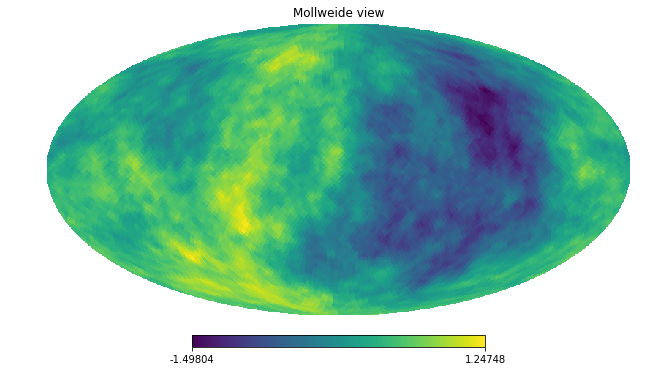

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


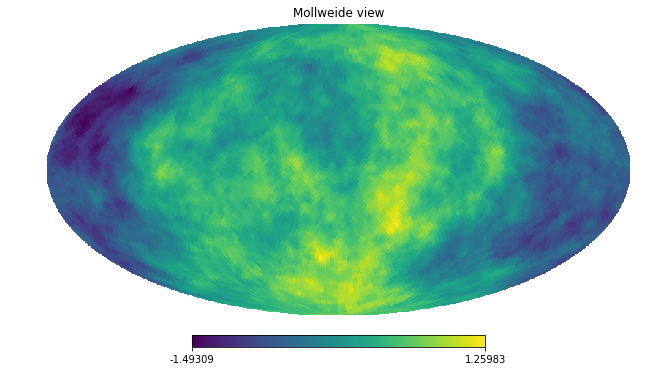

In [3]:
nside=32
lmax = 3*nside-1
degrees = np.arange(lmax+1, dtype=float)
degrees[0] = np.inf
power = degrees**(-3) ## just for plotting

hmap = hp.sphtfunc.synfast(power, nside=nside)
hp.visufunc.mollview(hmap)
plt.show()

rot = hp.rotator.Rotator(rot=[100,0, 0])
R_hmap = rot.rotate_map_alms(hmap)
hp.visufunc.mollview(R_hmap)

In [4]:
sphere = FullHEALPix(32)

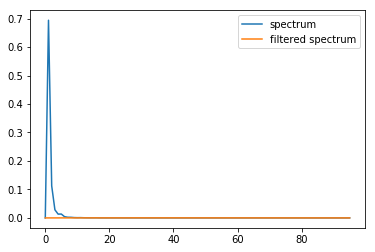

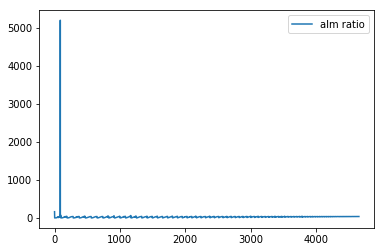

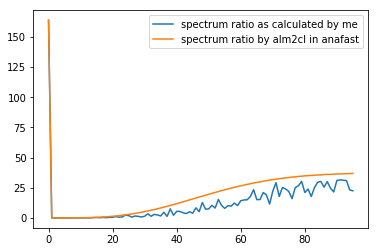

In [38]:
_var = equivariance_error(hmap, sphere.L)

### It seems correct
However, it seems I have __very big numerical errors.__ Let's have a look at the variance of the ration of the absolute values of the alms grouped by degree. As Michael explained, for a perfectly rotation equivariant filter, it should be zero.

In [65]:
def show_alm_ratio_variance_by_degree(hmap, L):
    spec, alm = hp.sphtfunc.anafast(hmap, alm=True)
    Lspec, Lalm = hp.sphtfunc.anafast(L@hmap, alm=True)
    
    alm_ratio = (np.abs(Lalm)**2)/(np.abs(alm)**2)
    
    var = np.zeros(len(spec))
    n = len(alm)
    lmax = int((-1+np.sqrt(1+8*n))/2)-1
    for l in range(lmax+1):
        ratio_0 = alm_ratio[l*(l+1)//2]
        positive_ratio = alm_ratio[l*(l+1)//2+1 : (l+1)*(l+2)//2]
        full_ratio = np.zeros(2*l+1)
        full_ratio[0] = ratio_0
        full_ratio[1:l+1] = positive_ratio
        full_ratio[l+1:] = positive_ratio
        var[l] = np.var(full_ratio)
  
    var[var>400] = 400
    plt.plot(var, 'bo', label='variance of the alm ratio by degree')
    plt.legend()
    #plt.ylim((0,1000))
    plt.show()

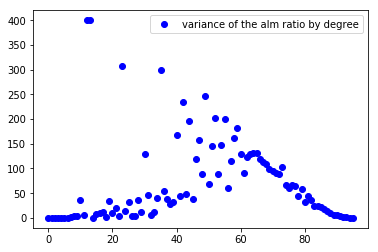

In [66]:
show_alm_ratio_variance_by_degree(hmap, sphere.L)

From this it seems reasonable to use the (inverse of) the mean variance as an indicator of rotation equivariance. Let's see what happens with the same filter __L__ built on graphs with different kernel width! 

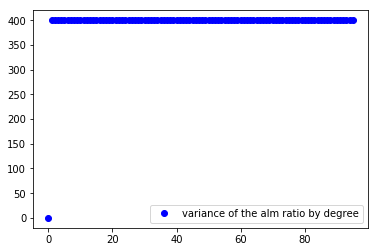

In [67]:
sphere1 = FullHEALPix(32, std=1)
show_alm_ratio_variance_by_degree(hmap, sphere1.L)